In [1]:
"""
For setting up local imports in an Ipython Shell
This is a workaround for ipython, dont need it for basic python scripts
"""
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
import IPython
import IPython.display

# Basic
import os
import datetime
import pandas as pd
import numpy as np

# Geometry
from pyefd import reconstruct_contour
from pyefd import elliptic_fourier_descriptors
from shapely.geometry import Polygon
from shapely.wkb import loads

# Local
from library import lib_aws

# PLotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# Scikit learn
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Tensorflow
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (20,5)
mpl.rcParams['axes.grid'] = False
plt.style.use('dark_background')

## Querying and Preprocessing the Data

In [4]:
# Query the Data from the db
# well_name = 'Cook 12-13 6B'
well_list = ['Cook 12-13 6B', 'Bonner 9-12H', 'Stenehjem 14-9H', 'Rolfson N 5198 12-17 5T']

query = """
SELECT 
    "NodeID",
    "Date",
    "pocdowncard",
    "Fillage",
    "SPM"
FROM
    xspoc.card
WHERE
    "NodeID" in {} 
    --    AND  "Date" BETWEEN '2018-03-19' AND '2020-05-26'
""".format(tuple(well_list))

with lib_aws.PostgresRDS(db='oasis-dev') as engine:
    data = pd.read_sql(query, engine, parse_dates=['Date'])
    
data.dropna(inplace=True)  # Nans arent present, but if they are will have to be droped
# COnverting the card data
data.pocdowncard = data.pocdowncard.apply(lambda x: loads(x, hex=True))
data.drop_duplicates(subset=['NodeID', 'Date'], inplace=True)
display(data.head())

Connected to oasis-dev DataBase
Connection Closed


,NodeID,Date,pocdowncard,Fillage,SPM
0,Bonner 9-12H,2019-01-22 13:30:13,"POLYGON ((10.10000038146973 -8889, 25.12000083...",98.1,2.0
1,Bonner 9-12H,2019-03-19 00:51:53,"POLYGON ((6.53000020980835 -8826, 21.870000839...",99.0,2.0
2,Bonner 9-12H,2019-03-19 02:41:29,"POLYGON ((10.06999969482422 -8892, 22.12999916...",91.0,2.0
3,Bonner 9-12H,2019-03-19 04:57:34,"POLYGON ((4.639999866485596 -9044, 17.45000076...",99.8,2.0
4,Bonner 9-12H,2019-03-19 06:41:44,"POLYGON ((6.300000190734863 -8971, 15.34000015...",100.0,1.2


In [5]:
class FD:
    @staticmethod
    def norm_static(xy, static_bounds):
        """
        Using a static pos-lod limits to normalize the cards
        :param xy: The Actual card pos and load values as a 2D array
        :param static_bounds: An array of [pos_min, pos_max, load_min, load_max]
        :return: Normalized Card (output is in the form of a 2D array of position and load)
        """
        [pos_min, pos_max, load_min, load_max] = static_bounds

        norm_pos = [((i - pos_min) / (pos_max - pos_min)) for i in xy[:, 0]]
        norm_load = [((i - load_min) / (load_max - load_min)) for i in xy[:, 1]]
        norm_xy = np.column_stack(([norm_pos, norm_load]))
        return norm_xy

    @staticmethod
    def norm_card(xy):
        """
        Just use the card values to normalize that specific card
        :param xy: The True Card pos-load values as a 2D-array
        :return: Normalized Card (As a 2D array of position and Load)
        """
        x_mx = np.max(xy[:, 0])
        x_mn = np.min(xy[:, 0])
        y_mx = np.max(xy[:, 1])
        y_mn = np.min(xy[:, 1])

        norm_x = [((i - x_mn) / (x_mx - x_mn)) for i in xy[:, 0]]
        norm_y = [((i - y_mn) / (y_mx - y_mn)) for i in xy[:, 1]]
        norm_xy = np.column_stack(([norm_x, norm_y]))
        return norm_xy

    @staticmethod
    def norm_df(xy, well, bounds_df):
        """
        This function will normalize the card depending on the limits for that well.
        Therefore we need a "bounds_df" which will include the pos-load limits for that particular well
        :param xy: True card pos-load values as an array
        :param well: The well this card belongs to
        :param bounds_df: A dataframe with pos-load limits as the index and Well Names as the column
        :return: Normalized Card (As a 2D array of position and Load)
        """
        pos_max = bounds_df.loc['pos_max', well]
        pos_min = bounds_df.loc['pos_min', well]

        load_max = bounds_df.loc['load_max', well]
        load_min = bounds_df.loc['load_min', well]

        norm_pos = [((i - pos_min) / (pos_max - pos_min)) for i in xy[:, 0]]
        norm_load = [((i - load_min) / (load_max - load_min)) for i in xy[:, 1]]
        norm_xy = np.column_stack(([norm_pos, norm_load]))
        return norm_xy
    
    def __init__(self, df, card_col, well_col):
        self.df = df.copy()
        self.card_col = card_col
        self.well_col = well_col
        
    def remove_errors(self):
        error_data = []
        for i in self.df.index:
            poly = self.df.loc[i, self.card_col]
            xy = np.asarray(poly.exterior.coords)
            
            try:
                fd = elliptic_fourier_descriptors(xy, order=2)
            except RuntimeWarning:
                fd = np.nan
                
            if np.isnan(fd).any():
                error_data.append(i)
        
#         print(f'Total error datapoints dropped {len(error_data)}')
        self.df.drop(error_data, inplace=True)
        self.df.reset_index(inplace=True, drop=True)
        return len(error_data)
        
    def well_bounds(self, df_well):
        min_max_arr = np.zeros([df_well.shape[0], 4])  # Initialize the empty array

        for i in df_well.index:
            poly = df_well.loc[i, self.card_col]
            min_max_arr[i, :] = list(poly.bounds)

        pos_min = np.min(min_max_arr[:, 0])
        pos_max = np.max(min_max_arr[:, 2])
        load_min = np.min(min_max_arr[:, 1])
        load_max = np.max(min_max_arr[:, 3])

        well_limits = [pos_min, pos_max, load_min, load_max]
        return well_limits

    def all_bounds(self):
        wells = self.df[self.well_col].unique()  # Unique wells in df
        min_max_dict = dict.fromkeys(wells)  # Empty dict with wells as keys

        for well in wells:
            df_well = self.df[self.df[self.well_col] == well]
            df_well.reset_index(drop=True, inplace=True)
            min_max_dict[well] = self.well_bounds(df_well)  # Call well_bounds method

        bounds_df = pd.DataFrame(min_max_dict)
        bounds_df.index = ['pos_min', 'pos_max', 'load_min', 'load_max']

        return bounds_df
    
    def feature_array(self, fd_order, area=False, centroid=False, norm_fn=None, norm_arg=None):
        n = self.df.shape[0]  # Number of rows in feature vector
        m = 0 # Initialize no of features as 0
        
        if fd_order:
            m += fd_order * 4
        if area:
            m += 1
        if centroid:
            m += 2
        
        x = np.zeros([n,m])
        
        for i in self.df.index:
            i_features = np.zeros([m,])
            poly = self.df.loc[i, self.card_col]
            well = self.df.loc[i, self.well_col]
            
            xy = np.asarray(poly.exterior.coords)
            
            # Normalizing
            if norm_fn == 'df':
                norm_xy = self.norm_df(xy, well, norm_arg)
            elif norm_fn == 'static':
                norm_xy = self.norm_static(xy, norm_arg)
            elif norm_fn == 'card':
                norm_xy = self.norm_card(xy)
            else:
                norm_xy = xy
            
            
            #Generate Features
            if fd_order:  # Add FD to feature matrix
                fd = elliptic_fourier_descriptors(norm_xy, order=fd_order, normalize=False)
                i_features[: fd_order * 4] = fd.flatten()
            if centroid:  # Centroid Added as i_features
                cent = list(Polygon(norm_xy).centroid.coords)
                i_features[fd_order * 4: (fd_order * 4 + 2)] = cent[0]
            if area:  # Area as a feature
                ar = Polygon(norm_xy).area
                i_features[-1] = ar
            
            x[i, :] = i_features  # Added to the main feature matrix
        
        return x

In [107]:
# Get Fourier Descriptors
fd_order = 8
fd = FD(df=data, well_col='NodeID', card_col='pocdowncard')
dropped_datapoints = fd.remove_errors()
bounds = fd.all_bounds()
fd_array = fd.feature_array(fd_order=fd_order, norm_fn='df', norm_arg=bounds)
# Fd DataFrame
# going ahead try putting it inside the FD class itself
feature_df = pd.concat([fd.df[['NodeID', 'Date']], pd.DataFrame(fd_array)], axis=1)

c:\users\rai_v\onedrive\python coursera\oasis\venv\lib\site-packages\pyefd.py:53: RuntimeWarning: invalid value encountered in true_divide
  phi = (2 * np.pi * t) / T
c:\users\rai_v\onedrive\python coursera\oasis\venv\lib\site-packages\pyefd.py:60: RuntimeWarning: invalid value encountered in true_divide
  cos_phi = (dxy[:, 0] / dt) * d_cos_phi
c:\users\rai_v\onedrive\python coursera\oasis\venv\lib\site-packages\pyefd.py:62: RuntimeWarning: invalid value encountered in true_divide
  b = consts * np.sum((dxy[:, 0] / dt) * d_sin_phi, axis=1)
c:\users\rai_v\onedrive\python coursera\oasis\venv\lib\site-packages\pyefd.py:63: RuntimeWarning: invalid value encountered in true_divide
  c = consts * np.sum((dxy[:, 1] / dt) * d_cos_phi, axis=1)
c:\users\rai_v\onedrive\python coursera\oasis\venv\lib\site-packages\pyefd.py:64: RuntimeWarning: invalid value encountered in true_divide
  d = consts * np.sum((dxy[:, 1] / dt) * d_sin_phi, axis=1)


In [108]:
feature_df.head()

,NodeID,Date,0,1,2,3,4,5,6,7,...,22,23,24,25,26,27,28,29,30,31
0,Bonner 9-12H,2019-01-22 13:30:13,-0.267024,0.214593,-0.218997,-0.245705,-0.005623,0.003893,0.000277,0.001421,...,-0.000238,0.001579,0.000619,-0.004039,-0.005430,-0.000140,-0.000494,0.002487,0.000966,0.000294
1,Bonner 9-12H,2019-03-19 00:51:53,-0.271881,0.224030,-0.211543,-0.256378,-0.005262,-0.000341,-0.001208,0.003098,...,-0.001064,0.001582,0.001036,-0.004085,-0.006079,-0.000487,-0.002045,0.002568,0.000846,0.000466
2,Bonner 9-12H,2019-03-19 02:41:29,-0.251744,0.219860,-0.233821,-0.242815,0.003420,0.004917,-0.001609,-0.009574,...,0.000331,-0.001213,-0.000870,-0.001636,-0.003698,0.001588,-0.001791,-0.000746,0.001319,0.000587
3,Bonner 9-12H,2019-03-19 04:57:34,-0.271049,0.225610,-0.211259,-0.254424,-0.008028,-0.000923,-0.001466,0.006265,...,-0.001756,0.002645,0.001730,-0.004456,-0.007420,-0.000781,-0.002474,0.001968,0.000035,0.000649
4,Bonner 9-12H,2019-03-19 06:41:44,-0.261178,0.206794,-0.214927,-0.244807,-0.008861,0.005412,0.000223,0.008620,...,-0.001106,0.003228,0.000229,-0.003375,-0.004644,0.001003,-0.001852,0.002160,-0.000583,0.000115


## Splitting the Data

In [109]:
# in the future add a window based additional cutoff as well
# This will avoid missing inital predictions cause no windows are present
cut_off_date = pd.Timestamp("2020-03-01") # Values afte this will be used as a final test data

# Final Test
final_test = feature_df[feature_df.Date >= cut_off_date]
final_test.reset_index(inplace=True, drop=True)
print(f"Final Test with size {final_test.shape[0]}")
# display(final_test.head())
# Data for building the model

# Training Data
full_training_df= feature_df[feature_df.Date < cut_off_date]
full_training_df.reset_index(inplace=True, drop=True)
print(f"Full Training Data(includes validation) with size {full_training_df.shape[0]}")
# display(full_training_df.head())

Final Test with size 1447
Full Training Data(includes validation) with size 12778


In [110]:
# Well Specifc Splits
print("Final Test Details")
display(final_test.groupby(["NodeID"]).agg({"Date": [min, max, "count"]}))

print("Full Training Data Details")
display(full_training_df.groupby(["NodeID"]).agg({"Date": [min, max, "count"]}))

Final Test Details


Date                          
                                        min                 max count
NodeID                                                               
Bonner 9-12H            2020-03-01 03:09:24 2020-05-25 19:49:35   335
Cook 12-13 6B           2020-03-01 00:28:47 2020-05-26 07:43:30   326
Rolfson N 5198 12-17 5T 2020-03-01 01:15:41 2020-04-11 04:51:27   275
Stenehjem 14-9H         2020-03-01 00:00:02 2020-05-26 05:04:34   511

Full Training Data Details


Date                          
                                        min                 max count
NodeID                                                               
Bonner 9-12H            2019-01-22 13:30:13 2020-02-29 23:50:40  2208
Cook 12-13 6B           2019-03-19 00:12:48 2020-02-29 21:20:34  3294
Rolfson N 5198 12-17 5T 2019-03-19 03:40:54 2020-02-29 22:42:50  2871
Stenehjem 14-9H         2019-03-19 00:28:46 2020-02-29 23:37:38  4405

## Model Training And Valdation

In [111]:
# well specific splitting 
# In the future implement window based split for val 
# ???Use dates to split instead of pct
# Pct for training
pct = 0.8
x_train =[ ]
x_val = []

for well in full_training_df.NodeID.unique():
    temp_df = full_training_df[full_training_df.NodeID == well]  # well based df
    split_len = int(len(temp_df) * pct) # split amount according to pct
    temp_train = temp_df.iloc[:split_len]  # training data
    temp_val = temp_df.iloc[split_len:]  # validation data
    x_train.append(temp_train)  # append to 
    x_val.append(temp_val)

# Merge to form dataframes
train_df = pd.concat(x_train)
train_df.reset_index(inplace=True, drop=True)
print(f"Training Data shape {len(train_df)}")

val_df = pd.concat(x_val)
val_df.reset_index(inplace=True, drop=True)
print(f"Validation Data shape {len(val_df)}")

Training Data shape 10221
Validation Data shape 2557


### Scaling

In [112]:
scaler = StandardScaler()

scaled_train = scaler.fit_transform(train_df.drop(columns = ["NodeID", "Date"]))
scaled_train_df = pd.concat([train_df[["NodeID", "Date"]], pd.DataFrame(scaled_train)], axis=1)

scaled_val = scaler.transform(val_df.drop(columns = ["NodeID", "Date"]))
scaled_val_df = pd.concat([val_df[["NodeID", "Date"]], pd.DataFrame(scaled_val)], axis=1)

In [113]:
# Well Specifc Splits
print("Training Data")
display(scaled_train_df.groupby(["NodeID"]).agg({"Date": [min, max, "count"]}))

print("Validation Data")
display(scaled_val_df.groupby(["NodeID"]).agg({"Date": [min, max, "count"]}))

Training Data


Date                          
                                        min                 max count
NodeID                                                               
Bonner 9-12H            2019-01-22 13:30:13 2020-01-04 11:09:05  1766
Cook 12-13 6B           2019-03-19 00:12:48 2019-11-24 15:49:21  2635
Rolfson N 5198 12-17 5T 2019-03-19 03:40:54 2019-12-21 10:13:52  2296
Stenehjem 14-9H         2019-03-19 00:28:46 2019-12-28 20:53:08  3524

Validation Data


Date                          
                                        min                 max count
NodeID                                                               
Bonner 9-12H            2020-01-04 14:12:09 2020-02-29 23:50:40   442
Cook 12-13 6B           2019-11-24 18:50:16 2020-02-29 21:20:34   659
Rolfson N 5198 12-17 5T 2019-12-21 13:13:56 2020-02-29 22:42:50   575
Stenehjem 14-9H         2019-12-29 00:13:19 2020-02-29 23:37:38   881

### Windowing 

In [114]:
feature_df

,NodeID,Date,0,1,2,3,4,5,6,7,...,22,23,24,25,26,27,28,29,30,31
0,Bonner 9-12H,2019-01-22 13:30:13,-0.267024,0.214593,-0.218997,-0.245705,-0.005623,0.003893,0.000277,0.001421,...,-0.000238,0.001579,0.000619,-0.004039,-0.005430,-0.000140,-0.000494,0.002487,0.000966,0.000294
1,Bonner 9-12H,2019-03-19 00:51:53,-0.271881,0.224030,-0.211543,-0.256378,-0.005262,-0.000341,-0.001208,0.003098,...,-0.001064,0.001582,0.001036,-0.004085,-0.006079,-0.000487,-0.002045,0.002568,0.000846,0.000466
2,Bonner 9-12H,2019-03-19 02:41:29,-0.251744,0.219860,-0.233821,-0.242815,0.003420,0.004917,-0.001609,-0.009574,...,0.000331,-0.001213,-0.000870,-0.001636,-0.003698,0.001588,-0.001791,-0.000746,0.001319,0.000587
3,Bonner 9-12H,2019-03-19 04:57:34,-0.271049,0.225610,-0.211259,-0.254424,-0.008028,-0.000923,-0.001466,0.006265,...,-0.001756,0.002645,0.001730,-0.004456,-0.007420,-0.000781,-0.002474,0.001968,0.000035,0.000649
4,Bonner 9-12H,2019-03-19 06:41:44,-0.261178,0.206794,-0.214927,-0.244807,-0.008861,0.005412,0.000223,0.008620,...,-0.001106,0.003228,0.000229,-0.003375,-0.004644,0.001003,-0.001852,0.002160,-0.000583,0.000115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14220,Stenehjem 14-9H,2020-05-25 22:24:22,-0.206353,0.122314,-0.148631,-0.100966,0.013921,0.016501,-0.016014,-0.019441,...,0.001520,-0.004344,0.001326,-0.001626,-0.006454,0.004389,0.000511,0.000092,0.000332,-0.001629
14221,Stenehjem 14-9H,2020-05-25 22:46:45,-0.206392,0.122901,-0.141627,-0.124927,-0.001684,-0.001114,0.000764,-0.002549,...,-0.001494,-0.001002,0.000380,-0.001492,-0.005261,0.004305,-0.000342,-0.000010,-0.000176,-0.001281
14222,Stenehjem 14-9H,2020-05-26 01:18:52,-0.214612,0.124991,-0.136721,-0.109458,0.013979,0.012137,-0.015147,-0.020590,...,0.002462,-0.002646,0.000313,0.001019,-0.004501,0.002248,-0.000708,-0.000441,0.000142,-0.000077
14223,Stenehjem 14-9H,2020-05-26 01:41:40,-0.212433,0.152152,-0.132282,-0.136679,0.000582,-0.004243,-0.003703,-0.002817,...,-0.000603,-0.002426,0.001152,0.001444,-0.006431,0.002995,-0.000776,-0.000669,-0.000649,-0.000885


In [79]:
def window_function(data, time_delta, input_size, shift, label_size, feature_slice=slice(None,None)):
    window_size = input_size + shift
    label_start = window_size - label_size
    delta = pd.Timedelta(time_delta)
    
    full_size = len(data) 
    
    x = []
    y = []
    t = []  # Predicted on times
    c = 0
    
    # Iterate over wells
    for well in data.NodeID.unique():
        temp_data = data[data.NodeID == well].copy()
        temp_data.set_index("Date", inplace=True)
        temp_data.sort_index(inplace=True)
        temp_data.drop(columns = ['NodeID'], inplace=True)
    #     display(temp_data.tail())        
        # Iterate over timestamps
        for i in temp_data.index:
            time_chunk = temp_data[i: i+delta]  # get the time chunk for that well
            if len(time_chunk) >= window_size:
                x.append(time_chunk.iloc[0: input_size].values)
                y.append(time_chunk.iloc[label_start:window_size, feature_slice].values)
                t.append([time_chunk.index[label_start], well])  # only label start used as number, for predictions use input end 
            else:
                c+=1

    x = np.array(x)
    y = np.array(y)
    y = y[:,0,:]  # For now only keeping one timestamp ahead predictions (this reshapes it into datapoints * features)
    t = np.array(t)

#     dataset = tf.data.Dataset.from_tensor_slices((x,y))
#     if shuffle_buffer is not None:
#         dataset = dataset.shuffle(shuffle_buffer)
#     if batch_size is not None:
#         dataset = dataset.batch(batch_size).prefetch(1)
    print(f'Datapoints dropped cause of the window params {round(c/full_size * 100, 2)} %') 
    return x, y, t

In [84]:
# Testing
window_params = {
    'time_delta': '20H',
    'input_size': 5,
    'shift': 1,
    'label_size': 1
}

xx, yy, tt = window_function(scaled_train_df, **window_params)

Datapoints dropped cause of the window params 6.28%


In [82]:
ds_ex = tf.data.Dataset.from_tensor_slices((xx,yy))
ds_ex = ds_ex.shuffle(1000)
ds_ex = ds_ex.batch(128).prefetch(1)


for inputs, labels in ds_ex.take(1):
    print(inputs.shape)
    print(labels.shape)

(128, 5, 4)
(128, 4)


## Building and Validating the Model

In [83]:
tf.keras.backend.set_floatx('float64')   # Beacuse our numpy arrays have 'float64' as default

### Dense Model

In [115]:
window_params = {
    'time_delta': '20H',
    'input_size': 5,
    'shift': 1,
    'label_size': 1
}

# Approx time_delta = 3 * total_window_size + 1h
# total_window_size = input_size + shift

In [86]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, LSTM, Dense

In [116]:
# Create tf Dataset
x_train, y_train, _ = window_function(scaled_train_df, **window_params)
x_val, y_val, _ = window_function(scaled_val_df, **window_params)

Datapoints dropped cause of the window params 6.28%
Datapoints dropped cause of the window params 3.21%


In [117]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

batch_size = 128
ds_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
ds_train = ds_train.batch(batch_size).prefetch(1)

ds_val = tf.data.Dataset.from_tensor_slices((x_val, y_val))
ds_val = ds_val.batch(batch_size).prefetch(1)

In [200]:
# Create a model
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    Conv1D(filters=64, kernel_size=10,strides=2, padding="causal", activation="tanh"),
    LSTM(32, return_sequences=True),
    LSTM(32),
    Dense(fd_order * 4),
#   tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(ds_train, epochs=100, validation_data=ds_val)

Epoch 1/100
75/75 [==============================] - 1s 18ms/step - loss: 0.3618 - mae: 0.7204 - val_loss: 0.3109 - val_mae: 0.6553
Epoch 2/100
75/75 [==============================] - 1s 11ms/step - loss: 0.2924 - mae: 0.6271 - val_loss: 0.2868 - val_mae: 0.6146
Epoch 3/100
75/75 [==============================] - 1s 10ms/step - loss: 0.2640 - mae: 0.5749 - val_loss: 0.2705 - val_mae: 0.5850
Epoch 4/100
75/75 [==============================] - 1s 10ms/step - loss: 0.2493 - mae: 0.5480 - val_loss: 0.2600 - val_mae: 0.5672
Epoch 5/100
75/75 [==============================] - 1s 10ms/step - loss: 0.2396 - mae: 0.5327 - val_loss: 0.2535 - val_mae: 0.5573
Epoch 6/100
75/75 [==============================] - 1s 11ms/step - loss: 0.2318 - mae: 0.5211 - val_loss: 0.2474 - val_mae: 0.5487
Epoch 7/100
75/75 [==============================] - 1s 11ms/step - loss: 0.2247 - mae: 0.5108 - val_loss: 0.2427 - val_mae: 0.5421
Epoch 8/100
75/75 [==============================] - 1s 10ms/step - loss: 0.

(1e-08, 0.0001, 0.0, 30.0)

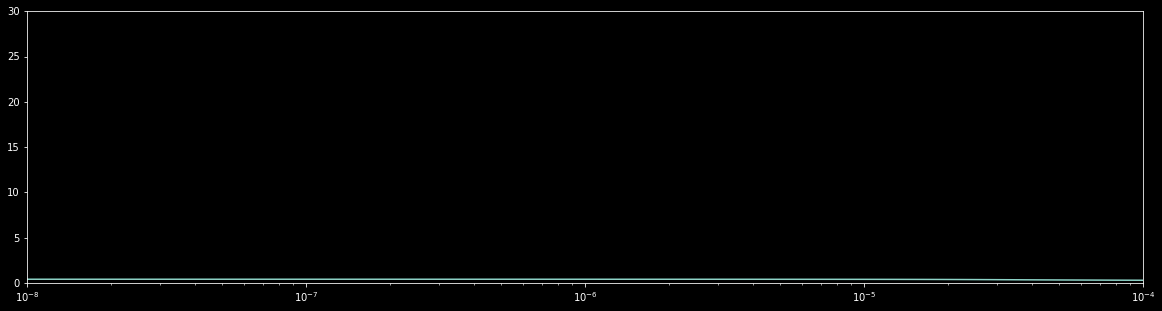

In [199]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.ylim((0,1))
plt.axis([1e-8, 1e-4, 0, 30])

In [201]:
# Metrics
model.evaluate(ds_val, verbose=1)

20/20 [==============================] - 0s 5ms/step - loss: 0.2697 - mae: 0.5613


[0.26974470760485136, 0.561296165997071]

<Figure size 1440x360 with 0 Axes>

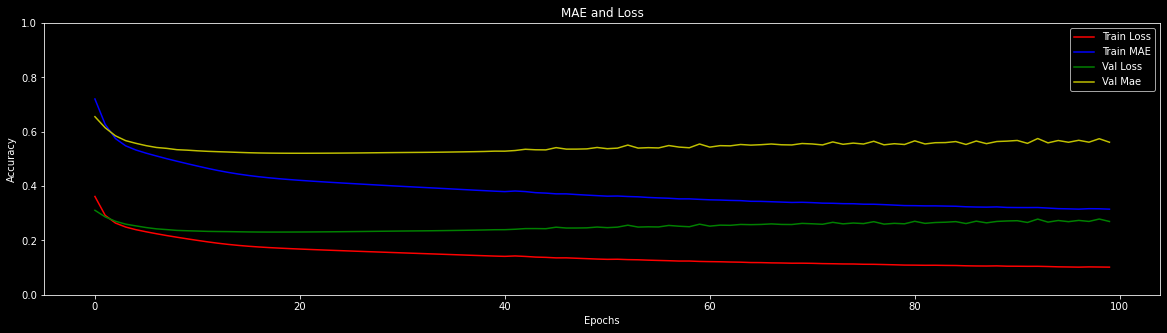

<Figure size 1440x360 with 0 Axes>

In [202]:
# Plot Validation Curves
history.history.keys()

train_loss = history.history['loss']
train_mae = history.history['mae']
val_loss = history.history['val_loss']
val_mae = history.history['val_mae']

epochs = range(len(train_loss))

# Plot full
plt.plot(epochs, train_loss, 'r')
plt.plot(epochs, train_mae, 'b')
plt.plot(epochs, val_loss, 'g')
plt.plot(epochs, val_mae, 'y')


plt.title("MAE and Loss")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['Train Loss', 'Train MAE', 'Val Loss', 'Val Mae'])
plt.ylim((0,1))

plt.figure()

<Figure size 1440x360 with 0 Axes>

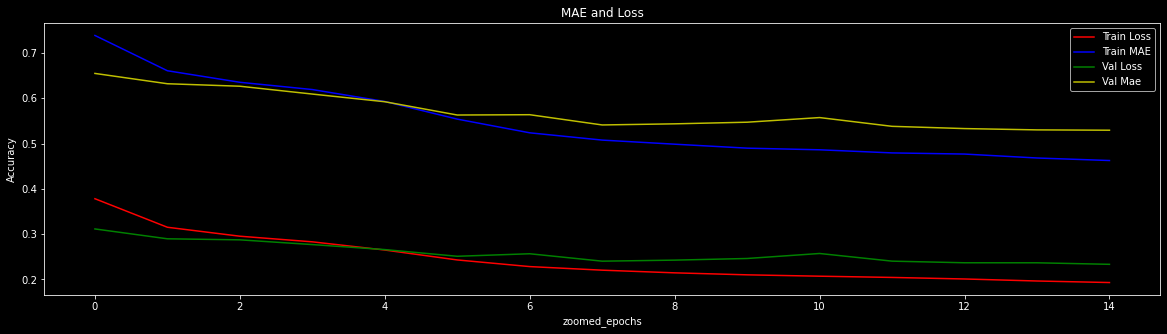

<Figure size 1440x360 with 0 Axes>

In [121]:
# Zoomed in validation cureves
cut = slice(None,15)

zoomed_train_loss = train_loss[cut]
zoomed_train_mae = train_mae[cut]
zoomed_val_loss = val_loss[cut]
zoomed_val_mae = val_mae[cut]

zoomed_epochs = epochs[cut]

# Plot full
plt.plot(zoomed_epochs, zoomed_train_loss, 'r')
plt.plot(zoomed_epochs, zoomed_train_mae, 'b')
plt.plot(zoomed_epochs, zoomed_val_loss, 'g')
plt.plot(zoomed_epochs, zoomed_val_mae, 'y')


plt.title("MAE and Loss")
plt.xlabel("zoomed_epochs")
plt.ylabel("Accuracy")
plt.legend(['Train Loss', 'Train MAE', 'Val Loss', 'Val Mae'])

plt.figure()

In [122]:
# Check if predictions are correct (in terms of dimensions)
y_pred = model.predict(ds_val)
y_pred = scaler.inverse_transform(y_pred)
y_pred.shape

(2475, 32)

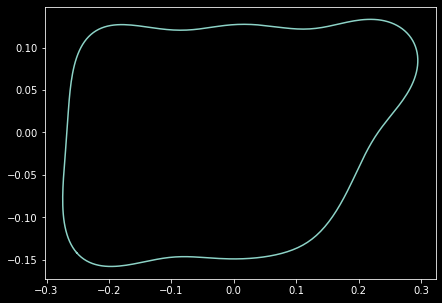

In [175]:
index = 2005
predicted_fourier = y_pred[index].reshape(fd_order,4)
pred_xy = reconstruct_contour(predicted_fourier)

fig = plt.figure(figsize=(7,5))
plt.plot(pred_xy[:,0], pred_xy[:,1])

## Predictions on New Data (Test Data)

In [170]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 5, 32)             5152      
_________________________________________________________________
lstm (LSTM)                  (None, 5, 32)             8320      
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
Total params: 22,848
Trainable params: 22,848
Non-trainable params: 0
_________________________________________________________________


### Single Window

In [146]:
# gloabal vareiable: fd_order
def single_window_prediction(index, data, test_model, time_delta, input_size, shift, label_size, sc=None):
    """
    Input an index from the test set and see what the card was predicted for that specific index
    Will use the inputs before the index with a size of input_size
    """
    delta = pd.Timedelta(time_delta)
    test_df = data.iloc[index-input_size: index].copy()
    
    # Test if datapoints are present for making predictions
    # Check if conditions match
    if len(test_df.NodeID.unique()) != 1:
        return print("Data from 2 diff wells")

    if (test_df.Date.max() - test_df.Date.min()) <= pd.Timedelta(delta):
        print("Timedelta is within requirements")
    else:
        return print("Cant continue not enough points in timedelta. Can force run if need be")
    
    # Predictions
    test_fd = test_df.iloc[:, 2:]  # get the features (fd)
    if sc is not None:
        test_fd = sc.transform(test_fd)  # scale them 
        
    pred_fd = test_model.predict(test_fd[np.newaxis]) # predict 
    pred_fd = sc.inverse_transform(pred_fd) # Inverse transform
    pred_fd = pred_fd.reshape(fd_order, 4)  # reshape
    pred_xy = reconstruct_contour(pred_fd)  # get xy
    
    # True
    wellname = final_test.loc[index, "NodeID"]  # get the wellname 
    date = final_test.loc[index, "Date"]  # get the date of prediction
    true_fd = final_test.iloc[index, 2:].values  # get the true fd
    true_fd = true_fd.reshape(fd_order, 4)  # reshape it
    true_xy = reconstruct_contour(true_fd)  # get true xy
    
    # PLot
    print(f"Predicted for time {date} for well {wellname}")
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(19,8))
    ax1.plot(true_xy[:,0], true_xy[:,1], label='True')
    ax1.set_title('True')
    ax2.plot(pred_xy[:,0], pred_xy[:,1], label='Predicted')
    ax2.set_title('Predicted')
    plt.show()

Timedelta is within requirements
Predicted for time 2020-03-21 00:02:52 for well Bonner 9-12H


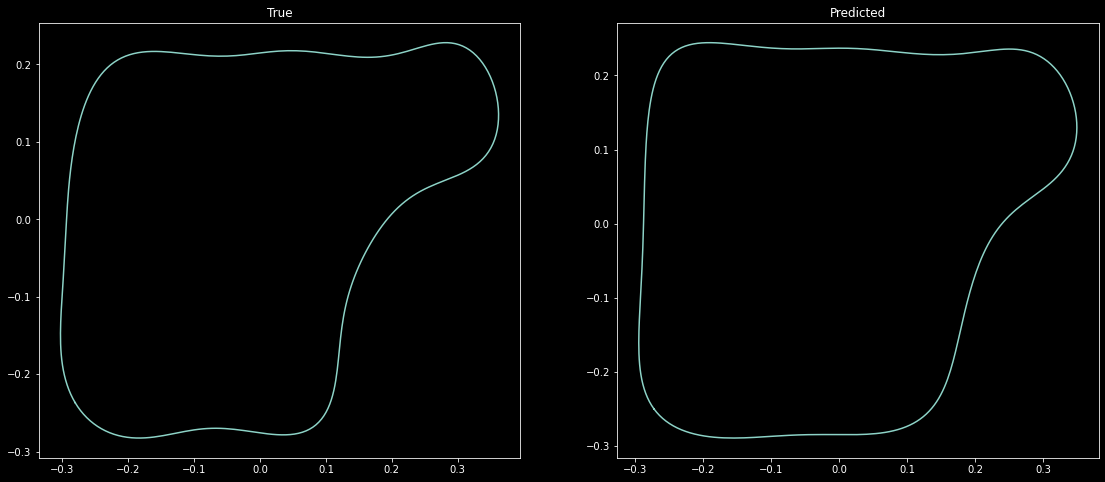

In [178]:
# Check Predictions
pred_index = 151
single_window_prediction(index=pred_index, data=final_test, sc=scaler, test_model=model,**window_params)

Timedelta is within requirements
Predicted for time 2020-03-20 18:23:17 for well Stenehjem 14-9H


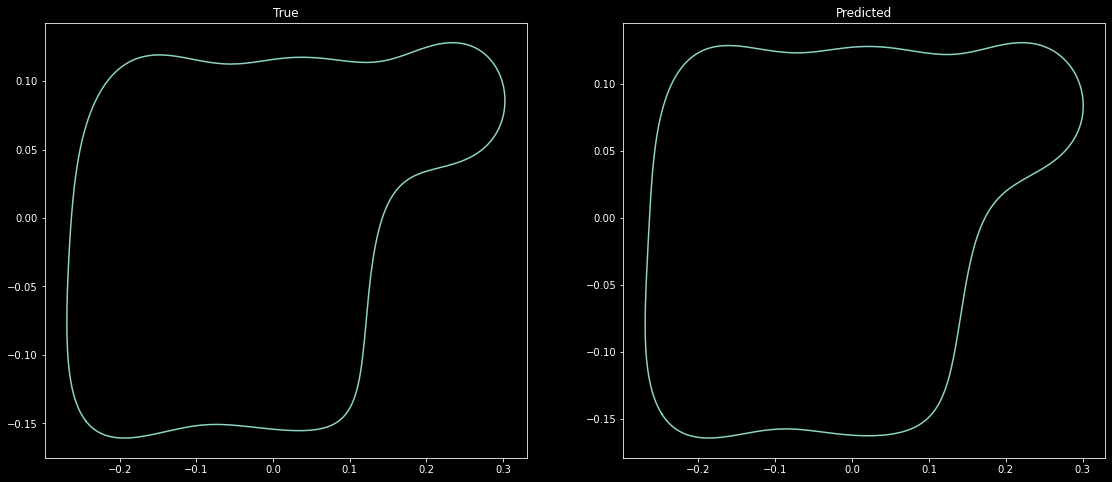

In [185]:
single_window_prediction(index=1226, data=final_test, sc=scaler, test_model=model,**window_params)